# Import

In [44]:
%load_ext autoreload
%autoreload 2
import re
import ast
import numpy as np
import json
import seaborn as sns
from scipy import stats
%matplotlib inline
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CMU DATASET ANALYSIS

In [45]:
DATA_FOLDER = './datasets/'

In [46]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER+'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

The goal of our study is to analyze what factors contribute to the success of a movie. Let us first have a quick analysis on our provided data set.


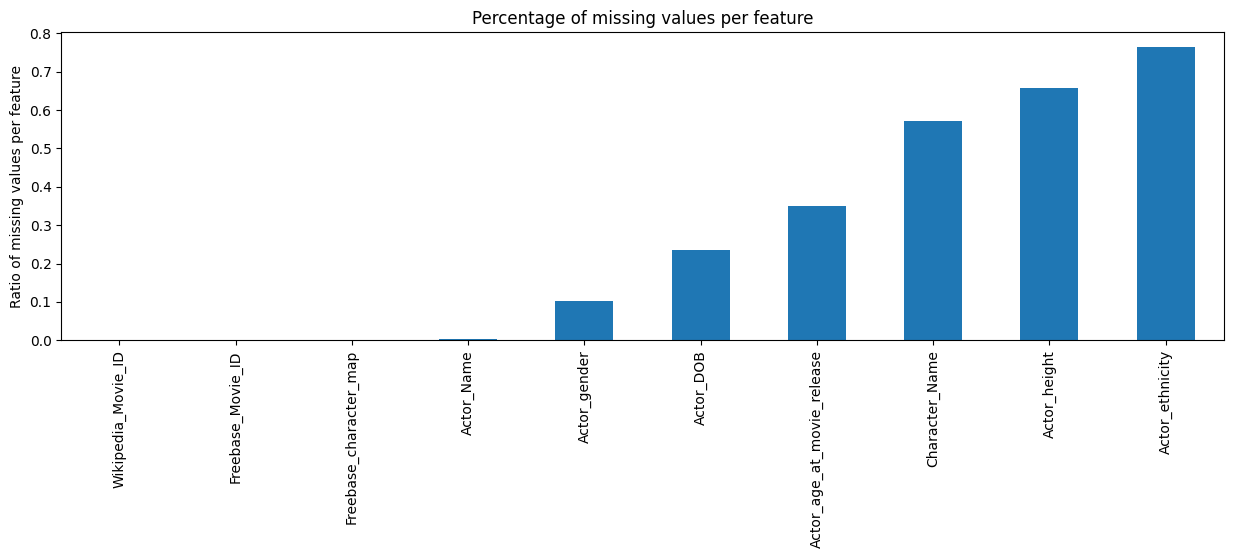

In [47]:
plot_missing_values_percentage(characters)

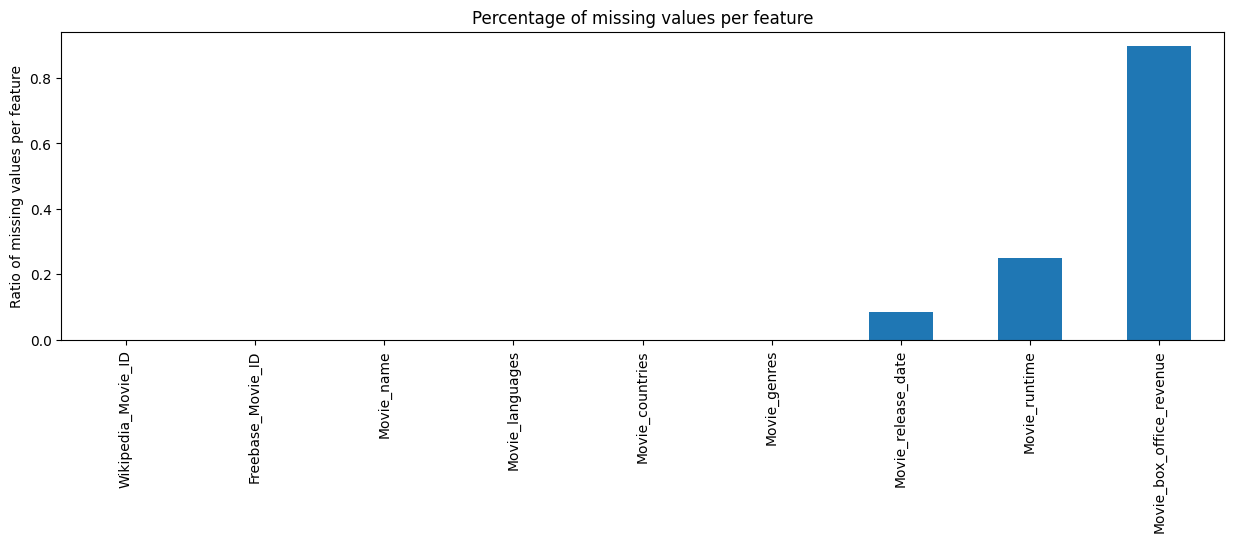

In [48]:
plot_missing_values_percentage(cmu_df)

**Comment:** Good factors to measure the success of a movie are its ratings and its revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.
**Solution:** Merge the CMU dataset with our additional dataset that contains ratings informations and additional box office revenues

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [49]:
data = query_wikidata()

In [50]:
imbd_freebase = json_to_df(data)

In [51]:
imbd_freebase.drop_duplicates(subset=['imdb_id','freebase_id'], inplace=True)

# 2. TMBD Analysis

In [52]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')

/var/folders/c6/1b0lb_gj5sscv1_rt1p35drm0000gn/T/ipykernel_2173/885709851.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


### Drop Non-related Columns

In [53]:
pd_tmbd = pd_tmbd.drop(['adult', 'belongs_to_collection',  'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'video'], axis=1)

#### Evaluate the literal value to convert it to array

In [54]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: safe_literal_eval(x))

#### Convert the initial dictonnaries into array of items

In [55]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: get_names(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: get_names(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: get_names(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: get_names(x))

### Merging the CMU and the TMDB Datasets

In [56]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID', how='inner').drop(columns='freebase_id')

In [57]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Box Office Revenue Data Consolidation

In [58]:
movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [59]:
movies['revenue'] = movies['revenue'].fillna(movies['Movie_box_office_revenue'])
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

### Preprocessing the genres, languages and countries columns

**Comment:** We have the columns mentioned above are represented as dictionaries with key freebase_id and values country names, genres and languages of the movie with id freebase_id, that's why we decided to retrieve the values and store them instead of having the dictionary representation

In [60]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [61]:
movies.drop(columns=['Wikipedia_Movie_ID','Movie_release_date', 'title', 'runtime', 'original_language', 'production_companies','id'], axis=1, inplace=True)

# Casting related feasability of the study

Now let us explore the characters data set in order to get a sense of how a study on the relationship between the success of a movie and it's casting.

In [62]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


DataFrame Shape: (450669, 10)

Data Types Counts:
object     7
float64    2
int64      1
Name: count, dtype: int64


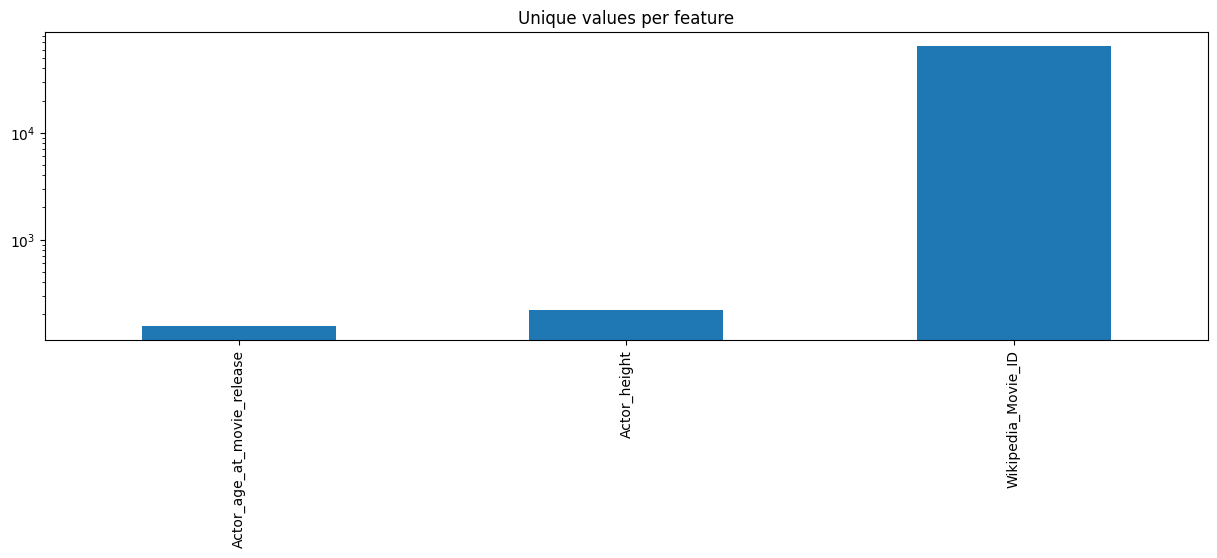

In [63]:
structural_analysis(characters)

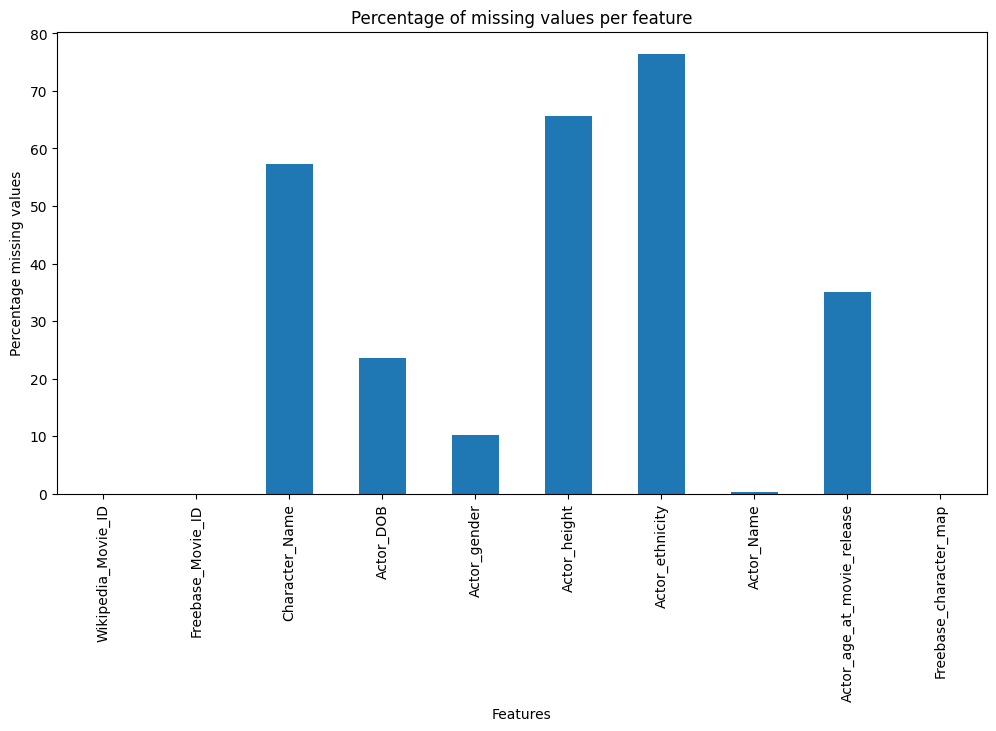

In [64]:
plot_nan(characters, 'Percentage of missing values per feature')

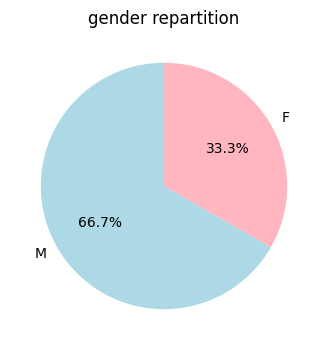

In [65]:
# Counting how many characters of each gender are there
gender_counts = characters['Actor_gender'].value_counts()

# Creating a pie chart
plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('gender repartition')
plt.show()

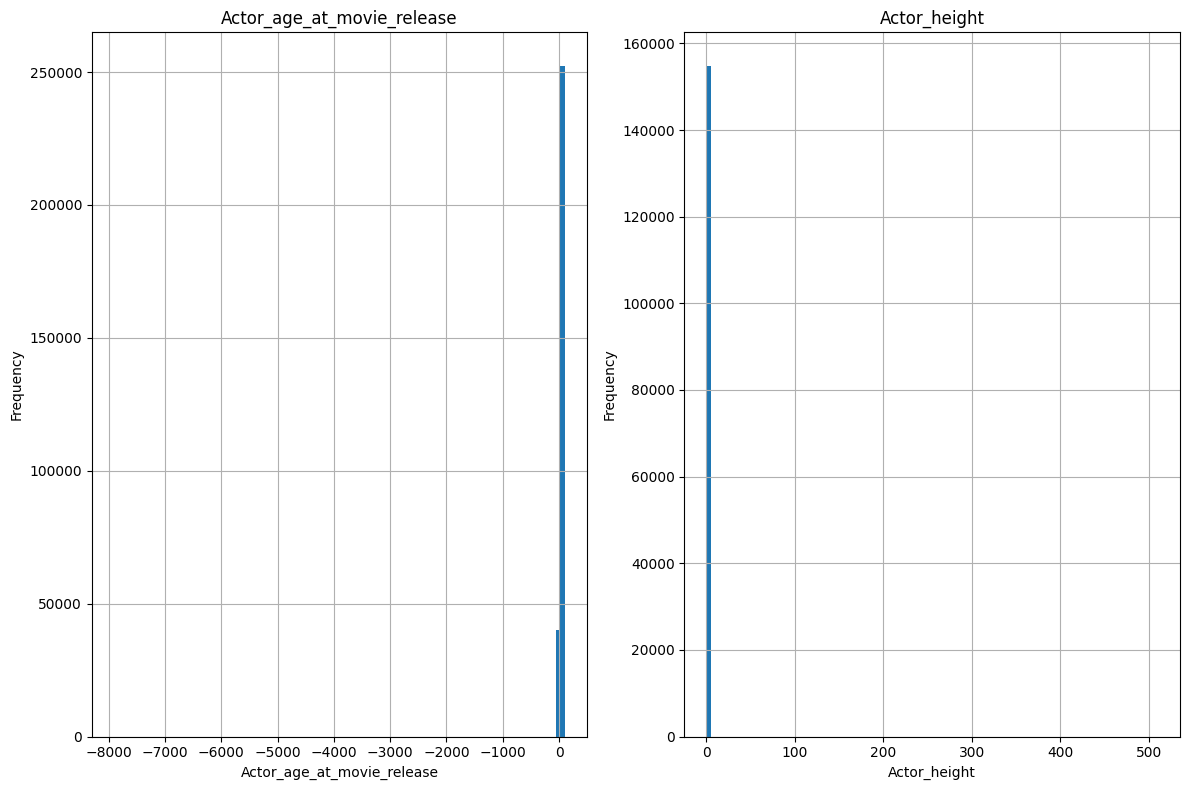

In [66]:
plot_histograms(characters,['Actor_age_at_movie_release','Actor_height'])

We can see that there are some outliers in our data frame, let us remove them and replot them


In [67]:
characters = characters[(characters['Actor_age_at_movie_release']>=0) & (characters['Actor_height']<3)]


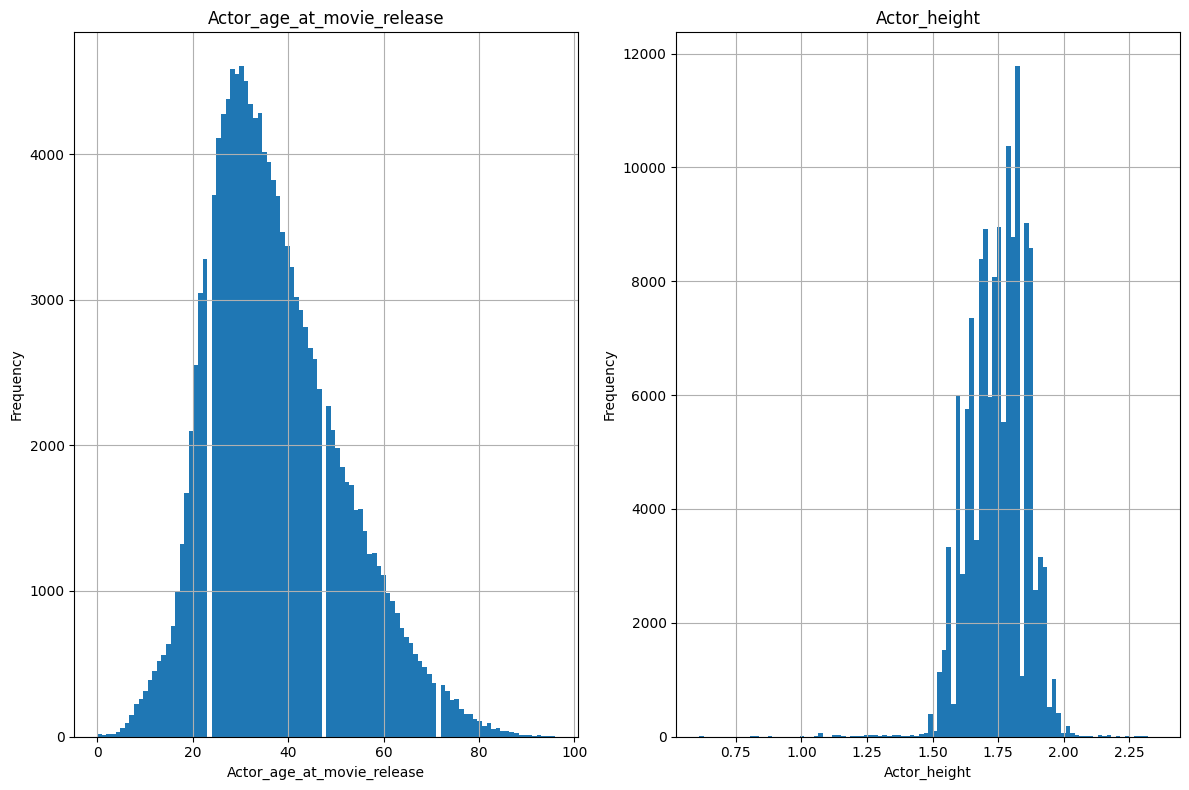

In [68]:
plot_histograms(characters,['Actor_age_at_movie_release','Actor_height'])

Now, let us look for how many movies we can find actors in the characters dataframe.

In [69]:
characters_with_movies = pd.merge(characters, movies, how = 'inner', on = 'Freebase_Movie_ID')
characters_with_movies.shape

(96950, 25)

After merging, the characters_with_movies will contain only the rows where the "freebase_movie_id" values match between the "characters" and "movies" dataframes. We see that we can find a matching movie for 96950 characters of our dataframe, which is sufficient for conducting a study